In [1]:
import numpy as np
import pandas as pd
import random as rn

import matplotlib.pyplot as plt
#from keras.callbacks import TensorBoard

import time
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn import datasets, linear_model

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable


In [2]:
# load dataset
subject_info = pd.read_csv("data/outd01_all_subject_info.txt", delimiter = " ")
print(subject_info.shape)

subject_info_all = pd.read_csv("data/pnc_subject_info.csv", delimiter = ",")
print(subject_info_all.shape)
# print(subject_info_all[:5])

# vbm analysis of cat12, 856 subjects. 
#It contains subjects in the ptsd group. So we need to remove them in training stage.
cat_vbm = pd.read_csv("data/ROI_catROI_neuromorphometrics_Vgm.csv", delimiter = ",")
#spm_vbm_aal = pd.read_csv("data/AvgExtract_GMV_AAL.csv", delimiter = "\t")
print(cat_vbm.shape)
# print(cat_vbm[:5])


(165, 4)
(8719, 6)
(856, 143)


In [3]:
## read label FA features:
label_fa_list = []
for i in range(6): 
    fa_sub = pd.read_csv("data/WMlabelResults_FA" + str(i+1) + ".csv")
    label_fa_list.append(fa_sub)

label_fa = pd.concat(label_fa_list, ignore_index = True)
label_fa.to_csv("data/WMlabelResults_FA_all.csv")
label_fa = label_fa.drop(['Unnamed: 0'], axis = 1)

# remove the last column which is empty.
num_col_fa=len(label_fa.columns) 
label_fa=label_fa.iloc[:,:num_col_fa-1]

print("label fa:")
print(label_fa.shape)
# print(label_fa[:5])

## read tract FA features:
tract_fa_list = []
for i in range(6): 
    fa_sub = pd.read_csv("data/WMtractResults_FA" + str(i+1) + ".txt", delimiter = "\t")
    tract_fa_list.append(fa_sub)

tract_fa = pd.concat(tract_fa_list, ignore_index = True)
tract_fa.to_csv("data/WMtractResults_FA_all.csv")

# print("tract fa:")
# print(tract_fa.shape)
# print(tract_fa[:5])

tract_fa = tract_fa.drop(['Unnamed: 0'], axis = 1)
# remove the last column which is empty.
num_col_fa=len(tract_fa.columns) 
tract_fa=tract_fa.iloc[:,:num_col_fa-1]

print("tract fa:")
print(tract_fa.shape)
# print(tract_fa[:5])


label fa:
(856, 50)
tract fa:
(856, 20)


In [4]:
## read tract MD features:
tract_md_list = []
for i in range(6): 
    md_sub = pd.read_csv("data/WMtractResults_MD" + str(i+1) + ".csv")
    tract_md_list.append(md_sub)

tract_md = pd.concat(tract_md_list, ignore_index = True)
tract_md.to_csv("data/WMtractResults_MD_all.csv")

# print("tract md:")
# print(tract_md.shape)
# print(tract_md.head(5))

# print(tract_md.iloc[:,0])
tract_md = tract_md.drop(['Unnamed: 0'], axis = 1)
# remove the last column which is empty.
num_col_md=len(tract_md.columns)
tract_md=tract_md.iloc[:,:num_col_md-1]

print("tract md:")
print(tract_md.shape)
# print(tract_md.head(5))

## read label MD features:
label_md_list = []
for i in range(6): 
    md_sub = pd.read_csv("data/WMlabelResults_MD" + str(i+1) + ".txt", delimiter = "\t")
    label_md_list.append(md_sub)

label_md = pd.concat(label_md_list, ignore_index = True)
label_md.to_csv("data/WMlabelResults_MD_all.csv")
label_md = label_md.drop(['Unnamed: 0'], axis = 1)

# remove the last column which is empty.
num_col_md=len(label_md.columns) 
label_md=label_md.iloc[:,:num_col_md-1]

print("label md:")
print(label_md.shape)
# print(label_md[:5])


tract md:
(856, 20)
label md:
(856, 50)


In [5]:
# combine vbm and label_fa
# it's strange that reset_index also removes column names. so we ignore_index in concat label_fa_list.
# otherwise, we cannot concat cat_vbm and label_fa.
# cat_vbm.reset_index(drop=True, inplace=True)
# label_fa_drop.reset_index(drop=True, inplace=True)

# read resting state features:
alff = pd.read_csv("data/ALFF_AvgExtract.txt", delimiter = "\t")
#print(alff.head(5))
alff = alff.drop(['Unnamed: 0'], axis = 1)
# remove the last column which is empty.
num_col_alff=len(alff.columns) 
alff=alff.iloc[:,:num_col_alff-1]
print("alff")
# print(alff.head(5))
print(alff.shape)

falff = pd.read_csv("data/fALFF_AvgExtract.txt", delimiter = "\t")
falff = falff.drop(['Unnamed: 0'], axis = 1)
# remove the last column which is empty.
num_col_falff=len(alff.columns) 
falff=falff.iloc[:,:num_col_falff-1]
print("falff")
print(falff.shape)

reho = pd.read_csv("data/Reho_AvgExtract.txt", delimiter = "\t")
reho = reho.drop(['Unnamed: 0'], axis = 1)
# remove the last column which is empty.
num_col_reho=len(reho.columns) 
reho=reho.iloc[:,:num_col_reho-1]
print("reho")
print(reho.shape)

ReHo = pd.concat([cat_vbm.names, reho], axis = 1)
ALFF = pd.concat([cat_vbm.names, alff], axis = 1)
fALFF = pd.concat([cat_vbm.names, falff], axis = 1)

fa = pd.concat([cat_vbm.names, label_fa, tract_fa], axis = 1)
md = pd.concat([cat_vbm.names, label_md, tract_md], axis = 1)

vbm_fa = pd.concat([cat_vbm, label_fa, tract_fa], axis = 1)
vbm_md = pd.concat([cat_vbm, label_md, tract_md], axis = 1)
vbm_dti = pd.concat([cat_vbm, label_fa, tract_fa, label_md, tract_md], axis = 1)

vbm_reho = pd.concat([cat_vbm, reho], axis = 1)
vbm_alff = pd.concat([cat_vbm, alff], axis = 1)
vbm_falff = pd.concat([cat_vbm, falff], axis = 1)

vbm_alff_reho = pd.concat([cat_vbm, alff, reho], axis = 1)
vbm_falff_reho = pd.concat([cat_vbm, falff, reho], axis = 1)

vbm_dti_alff_reho = pd.concat([cat_vbm, label_fa, tract_fa, label_md, tract_md, alff, reho], axis = 1)
vbm_dti_falff_reho = pd.concat([cat_vbm, label_fa, tract_fa, label_md, tract_md, falff, reho], axis = 1)

#brain_feature = pd.concat([cat_vbm, label_md_drop, tract_md_drop], axis = 1)
#brain_feature = cat_vbm

# print(brain_feature)
# print(brain_feature.head(5))

brain_feature_list = [[cat_vbm, "cat_vbm"], 
                      [ReHo, "reho"],
                      [ALFF, "alff"],
                      [fALFF, "falff"],
                      [fa, "fa"],
                      [md, "md"],
                      [vbm_fa, "vbm_fa"],
                      [vbm_md, "vbm_md"],
                      [vbm_dti, "vbm_dti"],
                      [vbm_alff, "vbm_alff"],
                      [vbm_falff, "vbm_falff"],
                      [vbm_reho, "vbm_reho"],
                      [vbm_alff_reho, "vbm_alff_reho"],
                      [vbm_falff_reho, "vbm_falff_reho"],
                      [vbm_dti_alff_reho, "vbm_dti_alff_reho"],
                      [vbm_dti_falff_reho, "vbm_dit_falff_reho"]
                     ]

alff
(856, 246)
falff
(856, 245)
reho
(856, 246)


In [6]:
# merge dataframes.
subject_info_merge = subject_info_all.merge(subject_info, how = "left", on = "SUBJID")
# subject_info_merge = subject_info_merge.merge(cat_vbm.names, how = "inner", left_on = "SUBJID", right_on = "names")
subject_info_merge['Sex_x'] = subject_info_merge['Sex_x'].replace({"F", "M"}, {0, 1})
subject_info_merge.ptsd = subject_info_merge.ptsd.fillna(0)

# remove samples with Med_rating higher than 1:
subject_info_merge = subject_info_merge.loc[subject_info_merge["Med_Rating"]<2]
print(subject_info_merge.shape)

subject_info_merge.to_csv("XXX_subject_info_merge.csv", sep = ",")

subject_info_hc = subject_info_merge.loc[subject_info_merge["ptsd"]==0]
subject_info_ptsd = subject_info_merge.loc[subject_info_merge["ptsd"]==2]
subject_info_trauma = subject_info_merge.loc[subject_info_merge["ptsd"]==1]


(4193, 9)


### Feature Selection

In [7]:
# get Features
vbm_dti_alff_reho, vbm_dti_alff_reho_name = brain_feature_list[14]
vbm_dti_alff_reho.shape

## prepare for data
# train model with all HC data:
brain_feature = vbm_dti_alff_reho

# merge subject info with brain imaging data:
feature_merge = subject_info_hc.merge(brain_feature, how = "inner", left_on = "SUBJID", right_on = "names")
Y_hc = feature_merge[["age_at_cnb"]].values
Y_hc = Y_hc.flatten()
# remove duplicated and unneeded features.
# Does adding Sex_x have any benefit???
feature_merge = feature_merge.drop(columns = ["SUBJID", "age_at_cnb", "Race", "ptsd", "Med_Rating", "Med_birth_year", "Sex_y", "age", "names"])
X_hc = feature_merge.values
# print(Y_hc)
# print(X_hc)

# remove NaNs:
nan_idx = np.isnan(Y_hc)
Y_hc = Y_hc[~nan_idx]
X_hc = X_hc[~nan_idx,:]

In [8]:
X = preprocessing.scale(X_hc)
age = Y_hc

### DNN with pytorch

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, age, test_size = 0.2, random_state = 42)

In [10]:
X_train1 = Variable(torch.from_numpy(X_train))
Y_train1 = Variable(torch.from_numpy(Y_train))
X_train1 = X_train1.float()
Y_train1 = Y_train1.float()

X_test1 = Variable(torch.from_numpy(X_test))
X_test1 = X_test1.float()

In [11]:
torch.manual_seed(999)    # reproducible
# https://discuss.pytorch.org/t/size-mismatch-beginner-troubles/16789
# model setup
n_hidden = 50
class Model(torch.nn.Module): 
    
    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(X.shape[1], 500)
        self.layer2 = nn.Linear(500, n_hidden)
        self.layer3 = nn.Linear(n_hidden, n_hidden)
        self.layer4 = nn.Linear(n_hidden, 1)
        
        self.sigmoid = torch.nn.Sigmoid()
        # self.dropout = nn.Dropout(0.5)  
            
    def forward (self, x):
        # out1 = F.relu(self.layer1(x)) # activation function for hidden layer
        out1 = self.sigmoid(self.layer1(x))
        #out1 = self.dropout(out1)
        out2 = self.sigmoid(self.layer2(out1))
        #out2 = self.dropout(out2)
        out3 = self.sigmoid(self.layer3(out2))
        #out3 = self.dropout(out3)
        y_pred = self.layer4(out3) # linear output
        return y_pred
    
net = Model()

In [12]:
# print(net) 

In [13]:

criterion = nn.MSELoss()# Mean Squared Loss
l_rate = 0.001
optimizer = torch.optim.SGD(net.parameters(), 
                            lr = l_rate, 
                            weight_decay=1e-6) 
#                             momentum=0.9, 
#                             nesterov=True) #Stochastic Gradient Descent

epochs = 2000 

In [15]:
inputs = X_train1
labels = Y_train1.view(Y_train.shape[0],1)
# Collect errors to evaluate performance
errorlist = [];
for epoch in range(epochs):

    #increase the number of epochs by 1 every time
    #epoch +=1
    
    #clear grads 
    optimizer.zero_grad()
    #forward to get predicted values
    outputs = net(inputs) # model predict,  outputs = net.forward(inputs)
    loss = criterion(outputs, labels)
    loss.backward()# back props
    optimizer.step()# update the parameters 
    
    errorlist = np.append(errorlist,loss.item()) 
    
    if epoch % 100 == 0:
        print('epoch {}, loss {:.2f}'.format(epoch,loss.data[0]))
    
#     if (epoch > 2100) & (epoch % 10 == 0):   
#         y_train_pred = net(X_train1)
#         y_train_pred = y_train_pred.detach().numpy()
#         corr_train = np.corrcoef(Y_train, y_train_pred.flatten())[0,1]
#         # print("Train data correlation %.3f " % corr_train)
        
#         X_prediction = net(X_test1)
#         X_prediction = X_prediction.detach().numpy()
#         corr_test = np.corrcoef(Y_test, X_prediction.flatten())[0,1]
#         print("Train, Test data correlation %.3f %.3f" % (corr_train, corr_test))

/home/xin/environments/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch 0, loss 3.27
epoch 100, loss 3.10
epoch 200, loss 2.94
epoch 300, loss 2.79
epoch 400, loss 2.65
epoch 500, loss 2.52
epoch 600, loss 2.41
epoch 700, loss 2.30
epoch 800, loss 2.21
epoch 900, loss 2.12
epoch 1000, loss 2.04
epoch 1100, loss 1.96
epoch 1200, loss 1.89
epoch 1300, loss 1.82
epoch 1400, loss 1.75
epoch 1500, loss 1.69
epoch 1600, loss 1.63
epoch 1700, loss 1.57
epoch 1800, loss 1.52
epoch 1900, loss 1.46


In [16]:
y_train_pred = net(X_train1)
y_train_pred = y_train_pred.detach().numpy()
corr_train = np.corrcoef(Y_train, y_train_pred.flatten())[0,1]
print("Train data correlation %.3f " % corr_train)

Train data correlation 0.932 


In [17]:
X_prediction = net(X_test1)
X_prediction = X_prediction.detach().numpy()
corr_test = np.corrcoef(Y_test, X_prediction.flatten())[0,1]
print("Test data correlation %.3f " % corr_test)

Test data correlation 0.849 


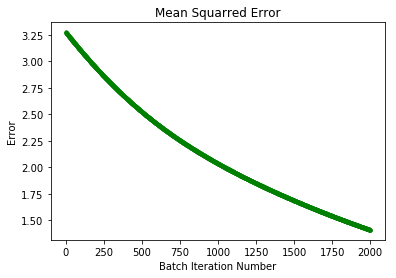

In [18]:
plt.plot(errorlist,'--.g')
plt.title("Mean Squarred Error")
plt.xlabel("Batch Iteration Number")
plt.ylabel("Error")
plt.show()

### Gaussian Process Regression

In [1]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel, ExpSineSquared, ConstantKernel as C

In [11]:
# kernel = DotProduct(1, (1e-2, 1e2)) + WhiteKernel(1,(0.01, 100)) # 8.26
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) + WhiteKernel(0.01) # 5.76
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

In [16]:
t0 = time.time()
gp.fit(X_train, Y_train)
gpr_fit = time.time() - t0
print("GPR complexity and bandwidth selected and model fitted in %.3f s"
      % gpr_fit)

GPR complexity and bandwidth selected and model fitted in 12.746 s


In [17]:
Y_pred_gpr, Y_std = gp.predict(X_test, return_std=True)
r_hc = np.corrcoef(Y_test.flatten(), Y_pred_gpr)
r_hc[1, 0]

0.8083699308613113

In [14]:
gp.kernel_

8.58**2 * RBF(length_scale=100) + WhiteKernel(noise_level=1.45)